## Data Prep

In [2]:
from utils import *

train_img_path = "/scratch/gza5dr/IrrigationTypeDetection/Experinments/Data/train_images/train_new_wboundary_array"
train_mask_path = "/scratch/gza5dr/IrrigationTypeDetection/Experinments/Data/train_masks/train_new_wboundary_img"
# train_img_path = "/scratch/gza5dr/IrrigationTypeDetection/Experinments/Data/train_images/train"
# train_mask_path = "/scratch/gza5dr/IrrigationTypeDetection/Experinments/Data/train_masks/train"
train_img_gen_1,train_img_gen_2 = trainGenerator(train_img_path, train_mask_path,batch_size, num_class=3,seed=42)


val_img_path = "/scratch/gza5dr/IrrigationTypeDetection/Experinments/Data/val_images/val_new_wboundary_array"
val_mask_path = "/scratch/gza5dr/IrrigationTypeDetection/Experinments/Data/val_masks/val_new_wboundary_img"
val_img_gen_1,val_img_gen_2 = trainGenerator(val_img_path, val_mask_path, batch_size, num_class=3,seed=42)

2024-03-19 18:32:10.726758: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `keras` framework.


2024-03-19 18:32:15.925695: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78651 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0


(256, 256, 3)
mask () 1
(256, 256, 1)
(256, 256, 4)
(256, 256, 4)
(256, 256, 3)
mask () 1
(256, 256, 1)
(256, 256, 4)
(256, 256, 4)


In [2]:
val_img_gen_1

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None)))>

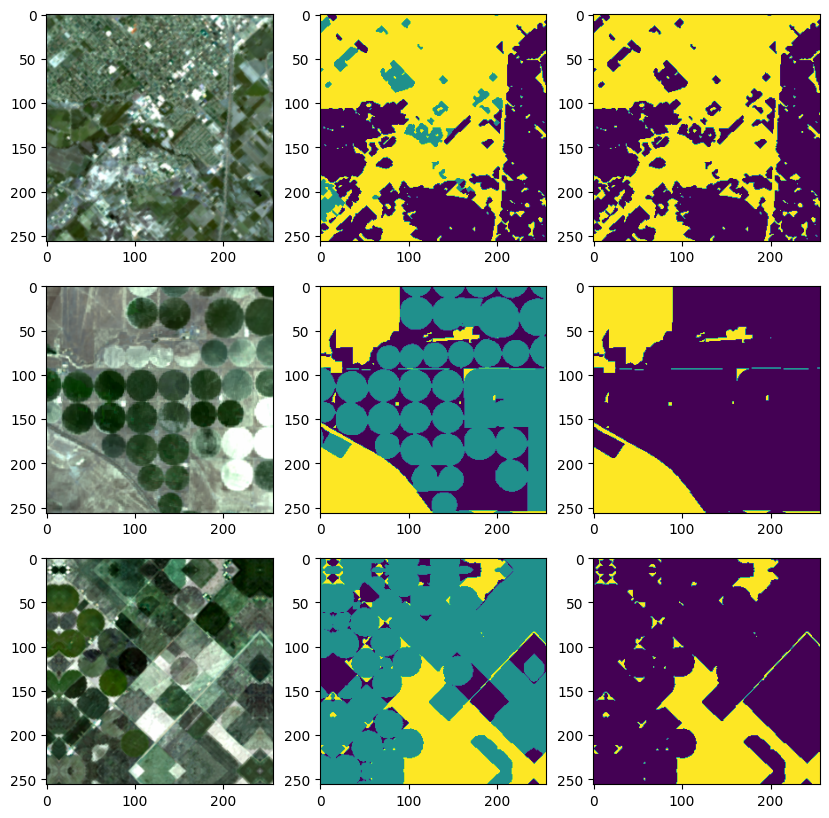

In [3]:
x = train_img_gen_1.take(15)
fig,axs = plt.subplots(3,3,figsize=(10, 10))
for images,labels in x:
    for i in range(3):
        image = images[i]
        # image = cv2.normalize(image, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        masks = np.argmax(labels[0][i],axis=-1)
        mask2 = np.argmax(labels[1][i],axis=-1)
        # print(labels[i])
        axs[i][0].imshow(image)
        axs[i][1].imshow(masks)
        axs[i][2].imshow(mask2)
    break

In [ ]:
x = val_img_gen_2.take(15)
fig,axs = plt.subplots(3,2,figsize=(10, 10))
for images,labels in x:
    for i in range(3):
        image = images[i].numpy()
        # image = cv2.normalize(image, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        masks = np.argmax(labels[i],axis=-1)
        # print(np.unique(masks))
        # masks=labels[i]
        # print(labels[i])
        axs[i][0].imshow(image)
        axs[i][1].imshow(masks)
    # break

#### Metrices

In [ ]:
def iou(y_true, y_pred, num_classes=2):
    y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=num_classes)
    ious = []
    for class_id in range(num_classes):
        # Extract slices for the true and predicted classes
        y_true_class = y_true[..., class_id]
        y_pred_class = y_pred[..., class_id]
        
        # Compute intersection and union for the current class
        intersection = tf.reduce_sum(y_true_class * y_pred_class, axis=[1, 2])
        union = tf.reduce_sum(y_true_class, axis=[1, 2]) + tf.reduce_sum(y_pred_class, axis=[1, 2]) - intersection
        
        # Avoid division by zero
        iou_score = intersection / (union + 1e-5)
        ious.append(iou_score)
    
    # Stack all class IoUs together
    ious = tf.stack(ious, axis=-1)
    
    # Calculate mean IoU across all classes
    mean_iou = tf.reduce_mean(ious, axis=-1)
    
    return mean_iou


def data_prep(y_true, y_pred,num_classes=2):
    y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    y_pred = tf.one_hot(tf.cast(y_pred, tf.int32), depth=num_classes)

    # Calculate per-class TP, FP, and FN
    tp = tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2])
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=[0, 1, 2])
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=[0, 1, 2])

  
    return tp, fp, fn
    
def pre_cal(y_true, y_pred,num_classes=2):
    tp, fp, fn = data_prep(y_true, y_pred,num_classes)
    precision = tp / (tp + fp + 1e-5)
    return precision
    
def rec_cal(y_true, y_pred,num_classes=2):
    tp, fp, fn = data_prep(y_true, y_pred,num_classes)
    recall = tp / (tp + fn + 1e-5)
    return recall
    
def f1_score(y_true, y_pred,num_classes=2):
    precision =  pre_cal(y_true, y_pred,num_classes)
    recall = rec_cal(y_true, y_pred,num_classes)
    f1_scores = 2 * ((precision * recall) / (precision + recall + 1e-5)) 
    return f1_scores
    
def precision_0(y_true, y_pred,num_classes=2):
    precision =  pre_cal(y_true, y_pred,num_classes)
    return precision[0]
    
def precision_1(y_true, y_pred,num_classes=2):
    precision =  pre_cal(y_true, y_pred,num_classes)
    return precision[1]
    
def precision_2(y_true, y_pred,num_classes=2):
    precision =  pre_cal(y_true, y_pred,num_classes)
    return precision[2]
    
def recall_0(y_true, y_pred,num_classes=2):
    recall = rec_cal(y_true, y_pred,num_classes)
    return recall[0]
    
def recall_1(y_true, y_pred,num_classes=2):
    recall = rec_cal(y_true, y_pred,num_classes)
    return recall[1]
    
def recall_2(y_true, y_pred,num_classes=2):
    recall = rec_cal(y_true, y_pred,num_classes)
    return recall[2]

    
def f1_score0(y_true, y_pred,num_classes=2):
    f1_scores=f1_score(y_true, y_pred,num_classes)
    return f1_scores[0]

    
def f1_score1(y_true, y_pred,num_classes=2):
    f1_scores=f1_score(y_true, y_pred,num_classes)
    return f1_scores[1]

    
def f1_score2(y_true, y_pred,num_classes=2):
    f1_scores=f1_score(y_true, y_pred,num_classes)
    return f1_scores[2]

### Resnet50 with Imagenet

In [6]:
n_classes_1 = 2
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),encoder_freeze=True,
                classes=n_classes_1, activation='softmax')
model.trainable = False

model_truncated = keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)

new_output = keras.layers.Conv2D(n_classes_1, (3, 3), padding='same', name='final_conv')(model_truncated.output)
new_output = keras.layers.Activation('softmax', name='softmax')(new_output)
model = keras.Model(inputs=model.input, outputs=new_output)


# model.summary()
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.001)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)

model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', 
              metrics=['accuracy',pre_cal,rec_cal,f1_score,iou]) 
history=model.fit(train_img_gen_2,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=2,
          validation_data=val_img_gen_2,
          validation_steps=val_steps_per_epoch)

model.save_weights('irr_nonirr_resnet_s1.weights.h5')


Epoch 1/10


2024-03-19 15:44:07.199061: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564c1fd9e8c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-19 15:44:07.199102: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-03-19 15:44:07.504746: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-19 15:44:08.366677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-03-19 15:44:13.207858: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


43/43 - 14s - 335ms/step - accuracy: 0.5071 - f1_score: 0.3847 - iou: 0.2762 - loss: 0.7466 - pre_cal: 0.4711 - rec_cal: 0.5072 - val_accuracy: 0.5155 - val_f1_score: 0.4050 - val_iou: 0.2869 - val_loss: 0.6998 - val_pre_cal: 0.5284 - val_rec_cal: 0.5082
Epoch 2/10
43/43 - 7s - 165ms/step - accuracy: 0.5413 - f1_score: 0.4809 - iou: 0.3326 - loss: 0.6885 - pre_cal: 0.5355 - rec_cal: 0.5219 - val_accuracy: 0.5262 - val_f1_score: 0.4818 - val_iou: 0.3293 - val_loss: 0.6921 - val_pre_cal: 0.5362 - val_rec_cal: 0.5245
Epoch 3/10
43/43 - 1s - 17ms/step - accuracy: 0.5407 - f1_score: 0.4867 - iou: 0.3355 - loss: 0.6888 - pre_cal: 0.5371 - rec_cal: 0.5244 - val_accuracy: 0.5280 - val_f1_score: 0.5053 - val_iou: 0.3434 - val_loss: 0.6913 - val_pre_cal: 0.5296 - val_rec_cal: 0.5250
Epoch 4/10
43/43 - 1s - 17ms/step - accuracy: 0.5393 - f1_score: 0.4980 - iou: 0.3405 - loss: 0.6887 - pre_cal: 0.5346 - rec_cal: 0.5255 - val_accuracy: 0.5286 - val_f1_score: 0.4831 - val_iou: 0.3315 - val_loss: 0.6

In [7]:
n_classes_1 = 2
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes_1, activation='softmax')
# model.trainable = False

model.load_weights('irr_nonirr_resnet_s1.weights.h5')
# model_truncated = keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)

# new_output = keras.layers.Conv2D(n_classes_1, (3, 3), padding='same', name='final_conv')(model_truncated.output)
# new_output = keras.layers.Activation('softmax', name='softmax')(new_output)
# model = keras.Model(inputs=model.input, outputs=new_output)


# # model.summary()
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.001)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)

model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', 
              metrics=['accuracy',pre_cal,rec_cal,f1_score,iou]) 
history=model.fit(train_img_gen_2,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          verbose=2,
          validation_data=val_img_gen_2,
          validation_steps=val_steps_per_epoch)

model.save_weights('irr_nonirr_resnet_s1.weights.h5')


# model.trainable = True
# model.summary()

Epoch 1/50
43/43 - 36s - 848ms/step - accuracy: 0.7429 - f1_score: 0.7403 - iou: 0.5792 - loss: 0.5221 - pre_cal: 0.7460 - rec_cal: 0.7446 - val_accuracy: 0.5125 - val_f1_score: 0.3638 - val_iou: 0.2671 - val_loss: 2630240768.0000 - val_pre_cal: 0.5558 - val_rec_cal: 0.5053
Epoch 2/50
43/43 - 20s - 467ms/step - accuracy: 0.7933 - f1_score: 0.7919 - iou: 0.6412 - loss: 0.4432 - pre_cal: 0.7940 - rec_cal: 0.7939 - val_accuracy: 0.5098 - val_f1_score: 0.3570 - val_iou: 0.2633 - val_loss: 314691616.0000 - val_pre_cal: 0.5330 - val_rec_cal: 0.5026
Epoch 3/50
43/43 - 2s - 41ms/step - accuracy: 0.7988 - f1_score: 0.7980 - iou: 0.6512 - loss: 0.4317 - pre_cal: 0.8000 - rec_cal: 0.7996 - val_accuracy: 0.4886 - val_f1_score: 0.3402 - val_iou: 0.2491 - val_loss: 5028772.5000 - val_pre_cal: 0.4459 - val_rec_cal: 0.4963
Epoch 4/50
43/43 - 2s - 40ms/step - accuracy: 0.8056 - f1_score: 0.8045 - iou: 0.6582 - loss: 0.4192 - pre_cal: 0.8055 - rec_cal: 0.8056 - val_accuracy: 0.4893 - val_f1_score: 0.336

In [8]:
def iou(y_true, y_pred, num_classes=3):
    y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=num_classes)
    ious = []
    for class_id in range(num_classes):
        # Extract slices for the true and predicted classes
        y_true_class = y_true[..., class_id]
        y_pred_class = y_pred[..., class_id]
        
        # Compute intersection and union for the current class
        intersection = tf.reduce_sum(y_true_class * y_pred_class, axis=[1, 2])
        union = tf.reduce_sum(y_true_class, axis=[1, 2]) + tf.reduce_sum(y_pred_class, axis=[1, 2]) - intersection
        
        # Avoid division by zero
        iou_score = intersection / (union + 1e-5)
        ious.append(iou_score)
    
    # Stack all class IoUs together
    ious = tf.stack(ious, axis=-1)
    
    # Calculate mean IoU across all classes
    mean_iou = tf.reduce_mean(ious, axis=-1)
    
    return mean_iou

def data_prep(y_true, y_pred,num_classes=3):
    y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    y_pred = tf.one_hot(tf.cast(y_pred, tf.int32), depth=num_classes)

    # Calculate per-class TP, FP, and FN
    tp = tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2])
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=[0, 1, 2])
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=[0, 1, 2])
    return tp, fp, fn
    
def pre_cal(y_true, y_pred,num_classes=3):
    tp, fp, fn = data_prep(y_true, y_pred,num_classes)
    precision = tp / (tp + fp + 1e-5)
    return precision
    
def rec_cal(y_true, y_pred,num_classes=3):
    tp, fp, fn = data_prep(y_true, y_pred,num_classes)
    recall = tp / (tp + fn + 1e-5)
    return recall

def f1_score(y_true, y_pred,num_classes=3):
    precision =  pre_cal(y_true, y_pred,num_classes)
    recall = rec_cal(y_true, y_pred,num_classes)
    f1_scores = 2 * ((precision * recall) / (precision + recall + 1e-5)) 
    return f1_scores
      

def precision_0(y_true, y_pred,num_classes=3):
    precision =  pre_cal(y_true, y_pred,num_classes)
    return precision[0]
    
def precision_1(y_true, y_pred,num_classes=3):
    precision =  pre_cal(y_true, y_pred,num_classes)
    return precision[1]
    
def precision_2(y_true, y_pred,num_classes=3):
    precision =  pre_cal(y_true, y_pred,num_classes)
    return precision[2]
    
def recall_0(y_true, y_pred,num_classes=3):
    recall = rec_cal(y_true, y_pred,num_classes)
    return recall[0]
    
def recall_1(y_true, y_pred,num_classes=3):
    recall = rec_cal(y_true, y_pred,num_classes)
    return recall[1]
    
def recall_2(y_true, y_pred,num_classes=3):
    recall = rec_cal(y_true, y_pred,num_classes)
    return recall[2]

    
def f1_score0(y_true, y_pred,num_classes=3):
    f1_scores=f1_score(y_true, y_pred,num_classes)
    return f1_scores[0]

    
def f1_score1(y_true, y_pred,num_classes=3):
    f1_scores=f1_score(y_true, y_pred,num_classes)
    return f1_scores[1]

    
def f1_score2(y_true, y_pred,num_classes=3):
    f1_scores=f1_score(y_true, y_pred,num_classes)
    return f1_scores[2]

i_model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=3, activation='softmax')

# inp = Input(shape=(None, None, 7))
# l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
# out = i_model(l1)

# i_model = Model(inp, out, name=model.name)


In [11]:
n_classes_1 = 2
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes_1, activation='softmax')
# model.trainable = False

model.load_weights('irr_nonirr_resnet_s1.weights.h5')
model_truncated = keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)

new_output = keras.layers.Conv2D(3, (3, 3), padding='same', name='final_conv')(model_truncated.output)
new_output = keras.layers.Activation('softmax', name='softmax')(new_output)
model = keras.Model(inputs=model.input, outputs=new_output)


# # model.summary()
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.00001)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
checkpoint_filepath = 'mode_ckpt/best_irr_3irr_resnet_s1.weights.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.compile(optimizer=keras.optimizers.Adam(3e-4), loss='categorical_crossentropy', 
              metrics=['accuracy',pre_cal,rec_cal,f1_score,iou]) 
history=model.fit(train_img_gen_1,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          verbose=2,
          validation_data=val_img_gen_1,
          validation_steps=val_steps_per_epoch,
          callbacks=[early_stop,reduce_lr,model_checkpoint_callback])

model.save_weights('irr_3irr_resnet_s1.weights.h5')


# model.trainable = True
# model.summary()

Epoch 1/50


2024-03-19 14:04:53.957975: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5573bd0c5660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-19 14:04:53.958021: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-03-19 14:04:54.627688: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-19 14:04:56.606713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-03-19 14:05:15.343847: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


43/43 - 41s - 952ms/step - accuracy: 0.4667 - f1_score: 0.3728 - iou: 0.2393 - loss: 1.0264 - pre_cal: 0.4066 - rec_cal: 0.4018 - val_accuracy: 0.4337 - val_f1_score: 0.4229 - val_iou: 0.2575 - val_loss: 1.0630 - val_pre_cal: 0.4682 - val_rec_cal: 0.4597 - learning_rate: 3.0000e-04
Epoch 2/50
43/43 - 23s - 529ms/step - accuracy: 0.5976 - f1_score: 0.5310 - iou: 0.3557 - loss: 0.8546 - pre_cal: 0.5451 - rec_cal: 0.5507 - val_accuracy: 0.3227 - val_f1_score: 0.3174 - val_iou: 0.1873 - val_loss: 1.0730 - val_pre_cal: 0.4915 - val_rec_cal: 0.4097 - learning_rate: 3.0000e-04
Epoch 3/50
43/43 - 2s - 39ms/step - accuracy: 0.6341 - f1_score: 0.5875 - iou: 0.3957 - loss: 0.7799 - pre_cal: 0.5904 - rec_cal: 0.5926 - val_accuracy: 0.2901 - val_f1_score: 0.2702 - val_iou: 0.1596 - val_loss: 1.1022 - val_pre_cal: 0.4777 - val_rec_cal: 0.3956 - learning_rate: 3.0000e-04
Epoch 4/50
43/43 - 2s - 40ms/step - accuracy: 0.6467 - f1_score: 0.6051 - iou: 0.4069 - loss: 0.7536 - pre_cal: 0.6111 - rec_cal: 0

In [14]:
history=model.fit(train_img_gen_1,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=2,
          validation_data=val_img_gen_1,
          validation_steps=val_steps_per_epoch,
          callbacks=[reduce_lr,model_checkpoint_callback])

model.save_weights('irr_3irr_resnet_s1.weights.h5')

Epoch 1/100
43/43 - 2s - 43ms/step - accuracy: 0.7433 - f1_score: 0.7172 - iou: 0.4629 - loss: 0.6068 - pre_cal: 0.7209 - rec_cal: 0.7215 - val_accuracy: 0.6597 - val_f1_score: 0.6071 - val_iou: 0.3933 - val_loss: 0.7800 - val_pre_cal: 0.6152 - val_rec_cal: 0.6152 - learning_rate: 1.0000e-05
Epoch 2/100
43/43 - 2s - 41ms/step - accuracy: 0.7451 - f1_score: 0.7205 - iou: 0.4633 - loss: 0.6016 - pre_cal: 0.7235 - rec_cal: 0.7232 - val_accuracy: 0.6689 - val_f1_score: 0.6181 - val_iou: 0.3999 - val_loss: 0.7626 - val_pre_cal: 0.6255 - val_rec_cal: 0.6201 - learning_rate: 1.0000e-05
Epoch 3/100
43/43 - 2s - 40ms/step - accuracy: 0.7408 - f1_score: 0.7133 - iou: 0.4616 - loss: 0.6091 - pre_cal: 0.7175 - rec_cal: 0.7188 - val_accuracy: 0.6660 - val_f1_score: 0.6004 - val_iou: 0.3996 - val_loss: 0.7770 - val_pre_cal: 0.6101 - val_rec_cal: 0.6104 - learning_rate: 1.0000e-05
Epoch 4/100
43/43 - 2s - 40ms/step - accuracy: 0.7414 - f1_score: 0.7155 - iou: 0.4621 - loss: 0.6079 - pre_cal: 0.7193 -

### Irr_model

In [ ]:
def iou(y_true, y_pred, num_classes=3):
    y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=num_classes)
    ious = []
    for class_id in range(num_classes):
        # Extract slices for the true and predicted classes
        y_true_class = y_true[..., class_id]
        y_pred_class = y_pred[..., class_id]
        
        # Compute intersection and union for the current class
        intersection = tf.reduce_sum(y_true_class * y_pred_class, axis=[1, 2])
        union = tf.reduce_sum(y_true_class, axis=[1, 2]) + tf.reduce_sum(y_pred_class, axis=[1, 2]) - intersection
        
        # Avoid division by zero
        iou_score = intersection / (union + 1e-5)
        ious.append(iou_score)
    
    # Stack all class IoUs together
    ious = tf.stack(ious, axis=-1)
    
    # Calculate mean IoU across all classes
    mean_iou = tf.reduce_mean(ious, axis=-1)
    
    return mean_iou

def data_prep(y_true, y_pred,num_classes=3):
    y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    y_pred = tf.one_hot(tf.cast(y_pred, tf.int32), depth=num_classes)

    # Calculate per-class TP, FP, and FN
    tp = tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2])
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=[0, 1, 2])
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=[0, 1, 2])
    return tp, fp, fn
    
def pre_cal(y_true, y_pred,num_classes=3):
    tp, fp, fn = data_prep(y_true, y_pred,num_classes)
    precision = tp / (tp + fp + 1e-5)
    return precision
    
def rec_cal(y_true, y_pred,num_classes=3):
    tp, fp, fn = data_prep(y_true, y_pred,num_classes)
    recall = tp / (tp + fn + 1e-5)
    return recall

def f1_score(y_true, y_pred,num_classes=3):
    precision =  pre_cal(y_true, y_pred,num_classes)
    recall = rec_cal(y_true, y_pred,num_classes)
    f1_scores = 2 * ((precision * recall) / (precision + recall + 1e-5)) 
    return f1_scores
      

def precision_0(y_true, y_pred,num_classes=3):
    precision =  pre_cal(y_true, y_pred,num_classes)
    return precision[0]
    
def precision_1(y_true, y_pred,num_classes=3):
    precision =  pre_cal(y_true, y_pred,num_classes)
    return precision[1]
    
def precision_2(y_true, y_pred,num_classes=3):
    precision =  pre_cal(y_true, y_pred,num_classes)
    return precision[2]
    
def recall_0(y_true, y_pred,num_classes=3):
    recall = rec_cal(y_true, y_pred,num_classes)
    return recall[0]
    
def recall_1(y_true, y_pred,num_classes=3):
    recall = rec_cal(y_true, y_pred,num_classes)
    return recall[1]
    
def recall_2(y_true, y_pred,num_classes=3):
    recall = rec_cal(y_true, y_pred,num_classes)
    return recall[2]

    
def f1_score0(y_true, y_pred,num_classes=3):
    f1_scores=f1_score(y_true, y_pred,num_classes)
    return f1_scores[0]

    
def f1_score1(y_true, y_pred,num_classes=3):
    f1_scores=f1_score(y_true, y_pred,num_classes)
    return f1_scores[1]

    
def f1_score2(y_true, y_pred,num_classes=3):
    f1_scores=f1_score(y_true, y_pred,num_classes)
    return f1_scores[2]

i_model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=2, activation='softmax')
i_model.load_weights('pm_resnet_s1.weights.h5')

i_model_truncated = keras.Model(inputs=i_model.inputs, outputs=i_model.layers[-3].output)

new_output = keras.layers.Conv2D(n_classes_2, (3, 3), padding='same', name='final_conv')(i_model_truncated.output)
new_output = keras.layers.Activation('softmax', name='softmax')(new_output)
i_model = keras.Model(inputs=i_model.input, outputs=new_output)

# Compile the modified model
i_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.000006), 
                       loss='categorical_crossentropy', 
                        metrics=['accuracy','precision','recall',f1_score,f1_score0,f1_score1,f1_score2,
                                precision_0,precision_1,precision_2,recall_0,recall_1,recall_2,iou])  # Adjust metrics as needed

history = i_model.fit(train_img_gen_1,
                             steps_per_epoch=steps_per_epoch,
                             epochs=50,
                             verbose=2,
                             validation_data=val_img_gen_1,
                             validation_steps=val_steps_per_epoch)

# Save the modified model's weights after training
i_model.save_weights('pm_resnet_s2_1.weights.h5')


#### Plot Metrics

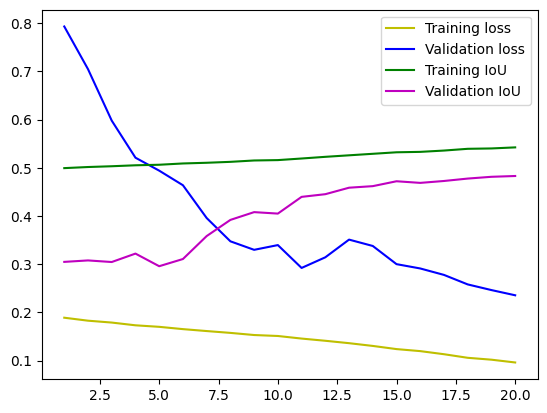

In [151]:
##################################################################
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['iou']
val_acc = history.history['val_iou']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.plot(epochs, acc, 'g', label='Training IoU')
plt.plot(epochs, val_acc, 'm', label='Validation IoU')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
plt.legend()
plt.show()




# plt.title('Training and validation IoU')
# plt.xlabel('Epochs')
# plt.ylabel('IoU')
# plt.legend()
# plt.show()

#####################################################

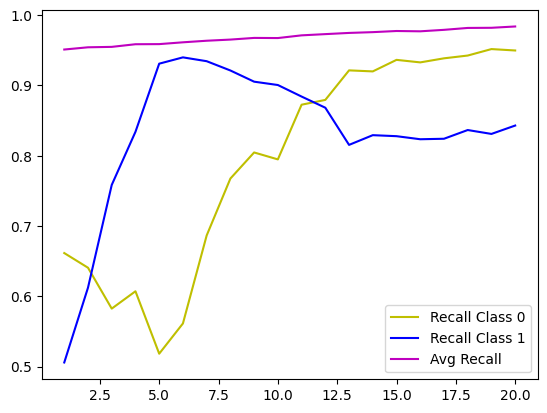

In [152]:
##################################################################
#plot the training and validation IoU and loss at each epoch
recall0 = history.history['val_recall_0']
recall1 = history.history['val_recall_1']
# recall2 = history.history['val_recall_2']
recalla = history.history['rec_cal']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, recall0, 'y', label='Recall Class 0')
plt.plot(epochs, recall1, 'b', label='Recall Class 1')
# plt.plot(epochs, recall2, 'g', label='Recall Class 2')
plt.plot(epochs, recalla, 'm', label='Avg Recall')
plt.legend()
plt.show()

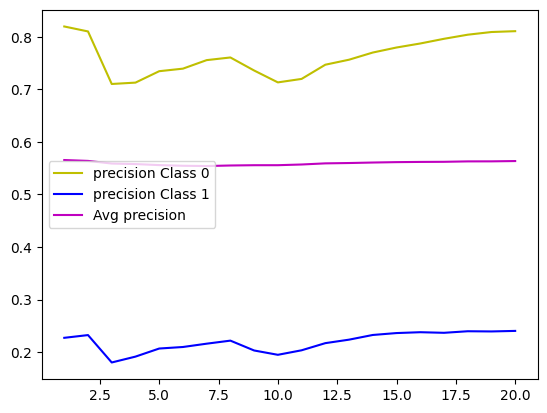

In [160]:
##################################################################
#plot the training and validation IoU and loss at each epoch
precision0 = history.history['val_precision_0']
precision1 = history.history['val_precision_1']
# precision2 = history.history['val_precision_2']
precisiona = history.history['pre_cal']


epochs = range(1, len(loss) + 1)
plt.plot(epochs, precision0, 'y', label='precision Class 0')
plt.plot(epochs, precision1, 'b', label='precision Class 1')
# plt.plot(epochs, precision2, 'g', label='precision Class 2')
plt.plot(epochs, precisiona, 'm', label='Avg precision')
plt.legend()
plt.show()

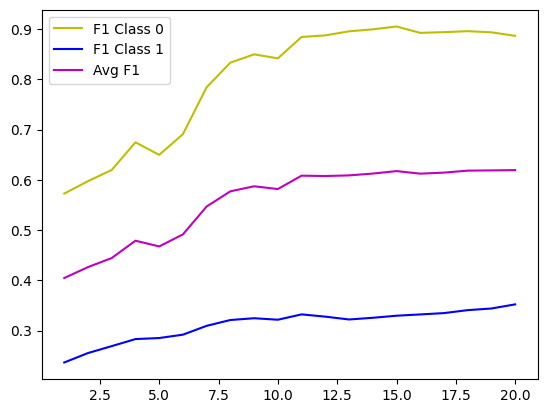

In [154]:
f1_0 = history.history['val_f1_score0']
f1_1 = history.history['val_f1_score1']
# f1_2 = history.history['val_f1_score2']
f1s = history.history['val_f1_score']


epochs = range(1, len(loss) + 1)
plt.plot(epochs, f1_0, 'y', label='F1 Class 0')
plt.plot(epochs, f1_1, 'b', label='F1 Class 1')
# plt.plot(epochs, f1_2, 'g', label='F1 Class 2')
plt.plot(epochs, f1s, 'm', label='Avg F1')
plt.legend()
plt.show()

In [16]:
model.load_weights('resnet.weights.h5')


/home/gza5dr/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:355: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 374 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


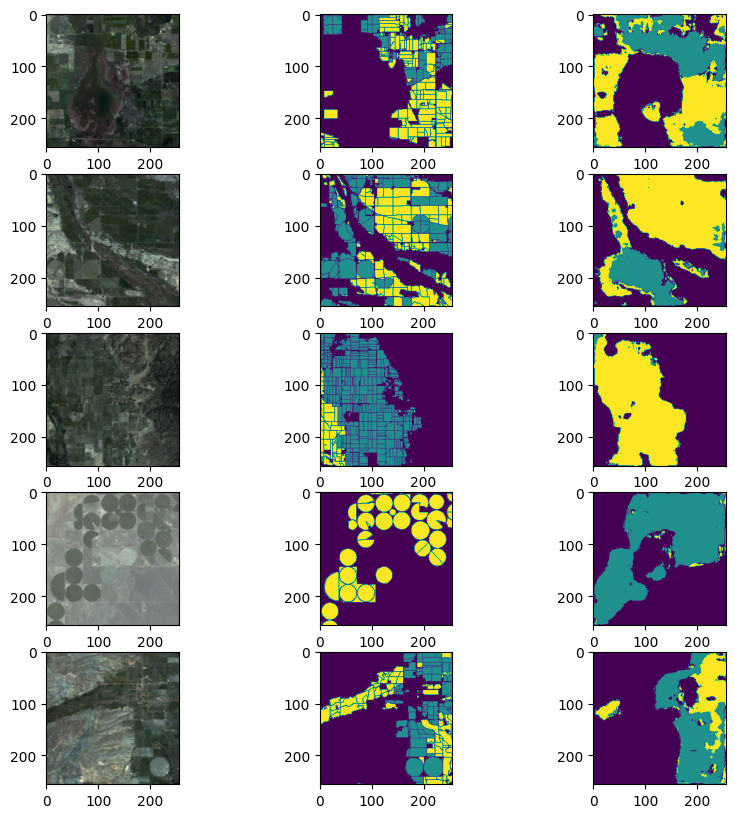

In [50]:
x = val_img_gen_1.take(1)
fig,axs = plt.subplots(5,3,figsize=(10, 10))
for images,labels in x:
    # print(images.shape)
    preds=i_model.predict(images)
    for i in range(5):
        image = images[i]
        masks = np.argmax(labels[i],axis=-1)
        print(preds[i].shape)
        pred_mask = np.argmax(preds[i],axis=-1)
        # print(labels[i])
        axs[i][0].imshow(image)
        axs[i][1].imshow(masks)
        axs[i][2].imshow(pred_mask)
    break

## Joint Learning

###### code 1

In [10]:
import tensorflow as tf
from keras import layers, Model
from keras.applications import ResNet50

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Multiply

def spatial_attention_module(feature_map):
    # Use a simple attention mechanism with global average pooling and a dense layer
    attention = GlobalAveragePooling2D()(feature_map)
    attention = layers.Reshape((1, 1, attention.shape[1]))(attention)
    attention = layers.Dense(feature_map.shape[-1], activation='sigmoid', use_bias=False)(attention)
    
    # Multiply the attention weights with the feature map
    attended_feature_map = Multiply()([feature_map, attention])
    return attended_feature_map

def create_multi_task_resnet50_model(input_shape, num_classes_boundary, num_classes_irrigation):
    # Load ResNet50 as the base model, without the top layer and with pre-trained ImageNet weights
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Optionally freeze the layers of ResNet50
    for layer in base_model.layers:
        layer.trainable = True
    
    # Base model outputs
    x = base_model.output
    y = base_model.output
    
    # Upsampling to match the input size. Adjust the number and scale of upsampling layers as necessary.
    # It's crucial to plan the upsampling steps to match the reduction in dimension due to strides in ResNet50.
    x = layers.Conv2DTranspose(256, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # Example upsampling
    x = layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # Continue as needed
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)   # Upsample to 256x256
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)   # Upsample to 256x256
    x = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)   # Upsample to 256x256
    
        # Upsampling to match the input size. Adjust the number and scale of upsampling layers as necessary.
    # It's crucial to plan the upsampling steps to match the reduction in dimension due to strides in ResNet50.
    y = layers.Conv2DTranspose(256, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(y)  # Example upsampling
    y = layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(y)  # Continue as needed
    y = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(y)   # Upsample to 256x256
    y = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(y)   # Upsample to 256x256
    y = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(y)   # Upsample to 256x256
    
    # # Additional convolutional layer(s) might be needed to refine the features after upsampling
    # x = layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    
    # Task 1: Boundary Detection - Outputting a spatial map for segmentation
    boundary_output = layers.Conv2D(num_classes_boundary, kernel_size=(1, 1), padding='same', activation='softmax', name='boundary_output')(y)
    
    # Task 2: Irrigation Type Classification - Outputting a spatial map for segmentation
    irrigation_output = layers.Conv2D(num_classes_irrigation, kernel_size=(1, 1), padding='same', activation='softmax', name='irrigation_output')(x)
    
    # Define the model with two outputs
    model = Model(inputs=base_model.input, outputs=[boundary_output, irrigation_output])
    
    return model


###### code 2

In [25]:
import tensorflow as tf
from keras import layers, Model
from keras.applications import ResNet50

def spatial_attention(feature_map):
    """Applies spatial attention to the given feature map."""
    attention_weights = layers.Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(feature_map)
    attended_feature_map = layers.Multiply()([feature_map, attention_weights])
    return attended_feature_map

def spatial_attention_module(feature_map):
    # Use a simple attention mechanism with global average pooling and a dense layer
    attention = GlobalAveragePooling2D()(feature_map)
    attention = layers.Reshape((1, 1, attention.shape[1]))(attention)
    attention = layers.Dense(feature_map.shape[-1], activation='sigmoid', use_bias=False)(attention)
    
    # Multiply the attention weights with the feature map
    attended_feature_map = Multiply()([feature_map, attention])
    return attended_feature_map

def channel_attention(feature_map, ratio=8):
    """Applies channel-wise attention to the given feature map."""
    channel = feature_map.shape[-1]
    shared_layer_one = layers.Dense(channel//ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)
    shared_layer_two = layers.Dense(channel, kernel_initializer='he_normal', use_bias=False)

    avg_pool = layers.GlobalAveragePooling2D()(feature_map)    
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = layers.GlobalMaxPooling2D()(feature_map)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    scale = layers.Add()([avg_pool, max_pool])
    scale = layers.Activation('sigmoid')(scale)

    attended_feature_map = layers.Multiply()([feature_map, scale])
    return attended_feature_map

def create_multi_task_resnet50_model(input_shape, num_classes_boundary, num_classes_irrigation):
    # Load ResNet50 as the base model
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Base model outputs
    base_output = base_model.output
    
    # Apply spatial attention for boundary detection task
    attended_spatial = spatial_attention(base_output)
    
    # Apply channel attention for irrigation type classification task
    attended_channel = channel_attention(base_output)
    
    # Upsample for boundary detection task
    x = layers.Conv2DTranspose(256, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(attended_spatial)  # Example upsampling
    x = layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # Continue as needed
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)   # Upsample to 256x256
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)   # Upsample to 256x256
    x = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)   # Upsample to 256x256
    boundary_output = layers.Conv2D(num_classes_boundary, (1, 1), activation='softmax', padding='same', name='boundary_output')(x)

    
    # Directly connect to MLP for irrigation type classification
    y = layers.GlobalAveragePooling2D()(attended_channel)  # Use GAP to reduce dimensions
    y = layers.Conv2DTranspose(256, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(attended_spatial)  # Example upsampling
    y = layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(y)  # Continue as needed
    y = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(y)   # Upsample to 256x256
    y = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(y)   # Upsample to 256x256
    y = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(y)   # Upsample to 256x256
    irrigation_output = layers.Conv2D(num_classes_irrigation, (1, 1), activation='softmax',padding='same', name='irrigation_output')(y)
    
    # Define the model with two outputs
    model = Model(inputs=base_model.input, outputs=[boundary_output, irrigation_output])
    
    return model


##### code_3

In [63]:
import tensorflow as tf
from keras import layers, Model, initializers
from keras.applications import ResNet50
from keras.layers import Layer,GlobalAveragePooling2D,Dense, Multiply, Add, Reshape
import keras.backend as K
import tensorflow as tf

def spatial_attention_module(feature_map):
    # Use a simple attention mechanism with global average pooling and a dense layer
    attention = GlobalAveragePooling2D()(feature_map)
    attention = layers.Reshape((1, 1, attention.shape[1]))(attention)
    attention = layers.Dense(feature_map.shape[-1], activation='softmax', use_bias=True)(attention)
    
    # Multiply the attention weights with the feature map
    attended_feature_map = Multiply()([feature_map, attention])
    return attended_feature_map

def get_decoder_layer(x):
    # x = layers.UpSampling2D((2,2))(x)

    
    for filters in [256, 128, 64,32,16]:
        x = layers.Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2), padding='same', use_bias=True,
        kernel_initializer=initializers.HeNormal(),activation='relu')(x) 
        x = layers.BatchNormalization()(x)

        # # x = layers.UpSampling2D((2,2))(x)
        # x = layers.Conv2DTranspose(filters, kernel_size=(3, 3), strides=2, padding='same', use_bias=True,
        #                               kernel_initializer=initializers.HeNormal(),activation='relu')(x) 
        # x = layers.BatchNormalization()(x)

        x = layers.Dropout(.2)(x)
        
        prev_block = x

        x = spatial_attention_module(x)

        # Project residual
        # residual = layers.UpSampling2D(2)(prev_block)
        residual = layers.Conv2D(filters, 1, padding="same")(prev_block)
        x = layers.add([x, residual])  # Add back residual
        prev_block = x
        
    return x
    
    
def create_multi_task_resnet50_model(input_shape, num_classes_binary, num_classes_irrigation):
    # Load ResNet50 as the base model
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    
    b_decoder = get_decoder_layer(x)
    i_decoder = get_decoder_layer(x)
    
        
    b_outputs =  layers.Conv2D(num_classes_irrigation, (3, 3), activation='softmax',padding='same', name='irrigation_output')(b_decoder)
    i_outputs =  layers.Conv2D(num_classes_binary, (3, 3), activation='softmax',padding='same', name='binary_output')(i_decoder)
    
    model = Model(inputs=base_model.input, outputs=[b_outputs,i_outputs])
    
    return model


In [64]:
model = create_multi_task_resnet50_model(input_shape=(256, 256, 3), num_classes_binary=2, num_classes_irrigation=3)


model.compile(optimizer='adam',
              loss={'irrigation_output': keras.losses.CategoricalCrossentropy(), 
                    'binary_output': 'categorical_crossentropy'},
              loss_weights={'irrigation_output': 1.0,  # Ensure this is a float
                            'binary_output': 1.5},  # Ensure this is a float
              metrics={'irrigation_output': ['accuracy','precision','recall'], 
                       'binary_output': ['accuracy','precision','recall']})

# ,f1_score,f1_score0,f1_score1,f1_score2,
#                                 precision_0,precision_1,precision_2,recall_0,recall_1,recall_2,iou

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics = ['accuracy','precision','recall',f1_score,f1_score0,f1_score1,f1_score2,
#                                 precision_0,precision_1,precision_2,recall_0,recall_1,recall_2,iou])

In [65]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
checkpoint_filepath = 'model_ckpt/irr_binary.model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
history = model.fit(train_img_gen_1,  # Assuming train_dataset is prepared accordingly
                    validation_data=val_img_gen_1,
                    steps_per_epoch=2*steps_per_epoch,
                    epochs=200,
                    verbose=2,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[reduce_lr,early_stop,model_checkpoint_callback])


Epoch 1/200
86/86 - 75s - 873ms/step - binary_output_accuracy: 0.5289 - binary_output_precision: 0.5808 - binary_output_recall: 0.5221 - irrigation_output_accuracy: 0.4429 - irrigation_output_precision: 0.4469 - irrigation_output_recall: 0.0273 - loss: 2.2027 - val_binary_output_accuracy: 0.5126 - val_binary_output_precision: 0.5696 - val_binary_output_recall: 0.5060 - val_irrigation_output_accuracy: 0.4853 - val_irrigation_output_precision: 0.4707 - val_irrigation_output_recall: 0.0019 - val_loss: 2.0954 - learning_rate: 0.0010
Epoch 2/200
86/86 - 21s - 250ms/step - binary_output_accuracy: 0.5410 - binary_output_precision: 0.5930 - binary_output_recall: 0.5330 - irrigation_output_accuracy: 0.4620 - irrigation_output_precision: 0.5726 - irrigation_output_recall: 0.0717 - loss: 2.1037 - val_binary_output_accuracy: 0.5334 - val_binary_output_precision: 0.5920 - val_binary_output_recall: 0.5253 - val_irrigation_output_accuracy: 0.4831 - val_irrigation_output_precision: 0.6169 - val_irriga

## Result Plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


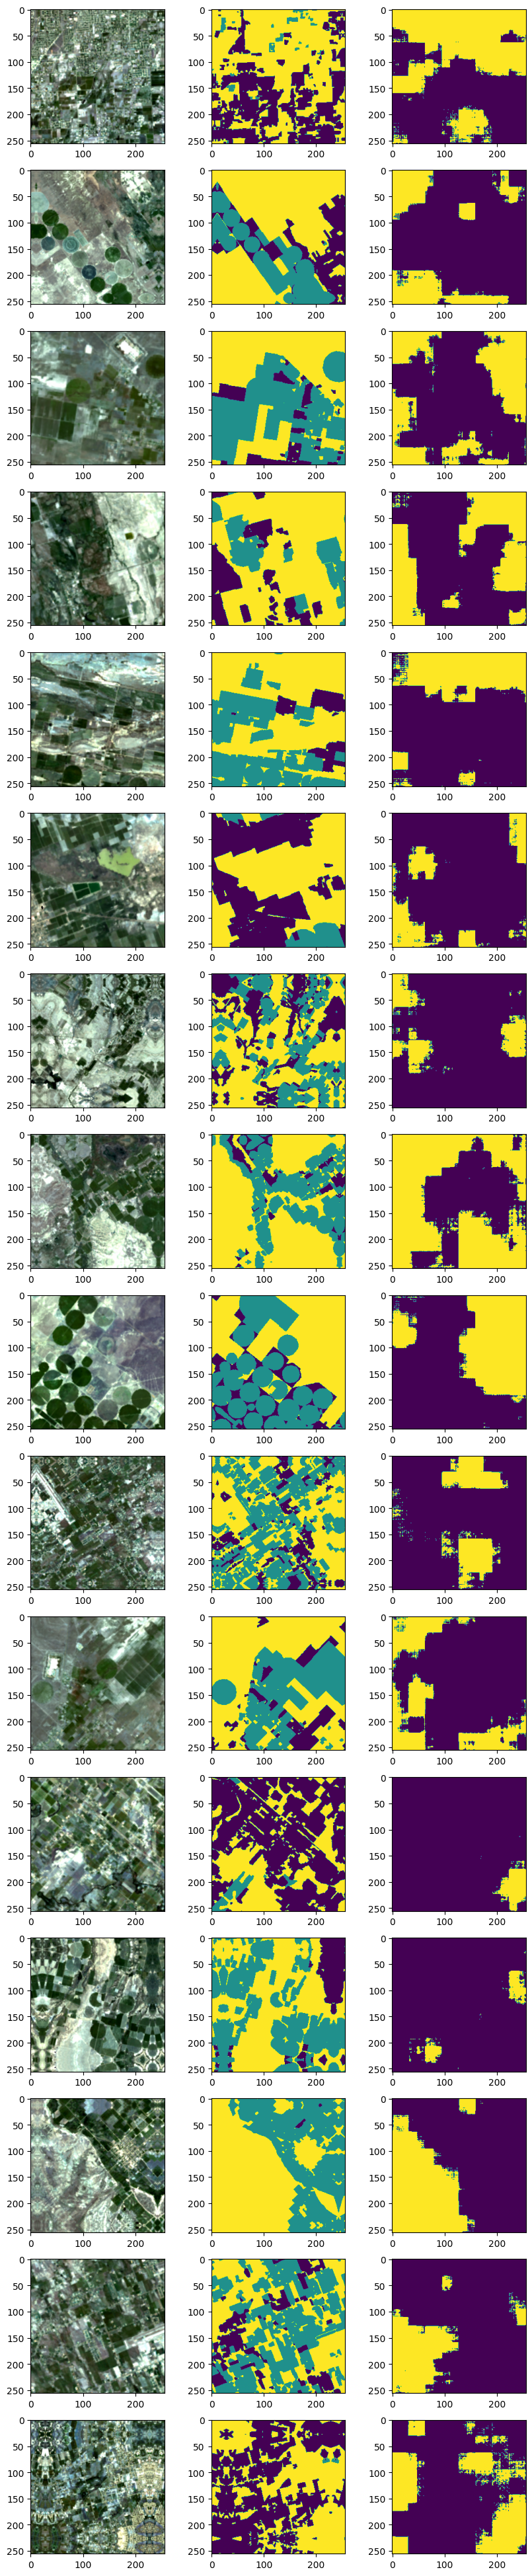

In [67]:
x = val_img_gen_1.take(1)
fig,axs = plt.subplots(16,3,figsize=(10, 50))
for images,labels in x:
    # print(images.shape)
    preds=model.predict(images)
    # print(np.array(preds).shape)
    for i in range(16):
        image = images[i].numpy()
        # image = cv2.normalize(image, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        masks = np.argmax(labels[0][i],axis=-1)
        pred_mask = np.argmax(preds[1][i],axis=-1)
        axs[i][0].imshow(image)
        axs[i][1].imshow(masks)
        axs[i][2].imshow(pred_mask)
    break
    
    